In [1]:
import glob
import struct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the file pattern is correct and should match all relevant files
files = glob.glob("data/data_info_101_*.bin")
# Sort files by name
files.sort()

# Read all files and accumulate bytes
my_bytes = b''
for file in files:
    with open(file, mode="rb") as f:
        my_bytes += f.read()

# Define column names and dtypes
columns_info = ["microstime",
                "pression", "temperature", "altitude", "pint", "pitot",
                "lat", "lon", "alt", "course", "speed", "hdop",
                "satellites", "gpstime", "apogee_detectee"]

dtypes_info = ['uint32',  # microstime
               'float32', 'float32', 'float32', 'float32', 'float32',  # sensor data
               'float64', 'float64', 'float64', 'float64', 'float64', 'float64',  # GPS data
               'uint32',  # satellites
               'uint32',  # gpstime
               'uint32_t']  # apogee_detectee

# Create the format string for struct.unpack
fmt = '<' + 'I'  # uint32_t for microstime
fmt += 'f' * 5  # 5 float32 for sensor data
fmt += 'd' * 6  # 6 float64 for GPS data
fmt += 'I' * 3  # 3 uint32_t for satellites and gpstime and apogee_detectee

# Calculate the size of one row in bytes
size = struct.calcsize(fmt)

# Keep the biggest multiple of size that is smaller than the number of bytes
num_complete_rows = len(my_bytes) // size 
my_bytes = my_bytes[:num_complete_rows * size]

# Convert bytes to pandas DataFrame
df_rows = []

for i in range(0, len(my_bytes), size):
    row_bytes = my_bytes[i:i + size]
    try:
        row = struct.unpack(fmt, row_bytes)
    except struct.error:
        row = [None] * len(columns_info)  # Handle any unpacking error by filling the row with None
    df_rows.append(row)

# Create DataFrame
df_info = pd.DataFrame(df_rows, columns=columns_info)
# drop the 4 first rows
df_info = df_info.iloc[4:]

t_info = df_info['microstime'] / 1e6

In [2]:
import pickle
# import cam data
with open('x.pkl', 'rb') as f:
    x = pickle.load(f)
    t_cam = pickle.load(f)

In [3]:
decollage_cam = 44.242
id_t0_cam = 43242
id_tf_cam = 104242

decollage_info = 1594.665
id_t0_info = 3103
id_tf_info = 12254

para = 12.821

In [4]:
file_name_suffix = "comp"

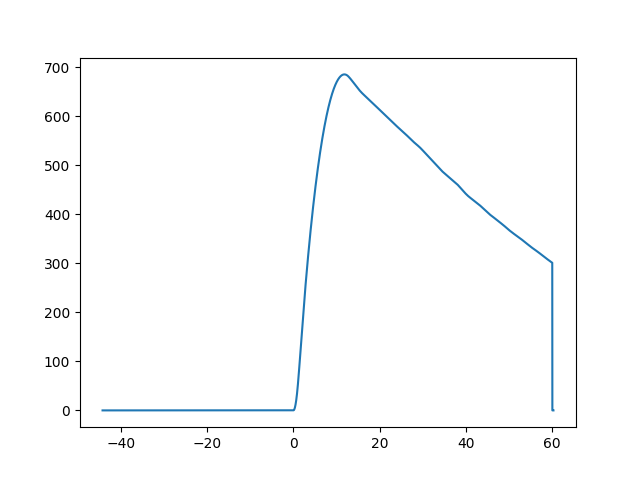

In [5]:
%matplotlib widget
plt.figure()
plt.plot(t_cam[:]-decollage_cam, x[:][:,5])

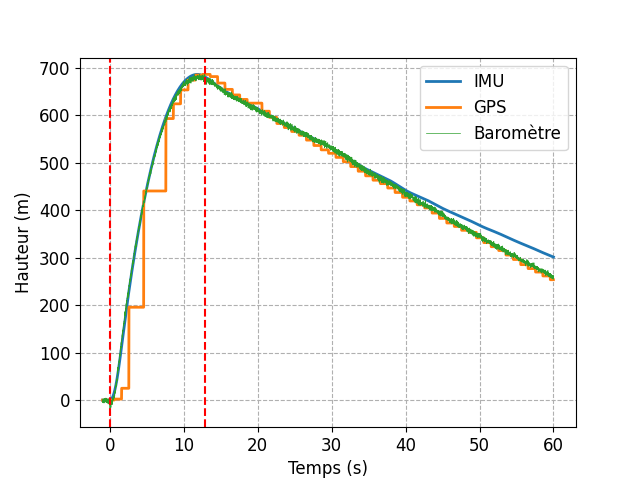

In [6]:
plt.figure()

# on renormalize les données pour les comparer
factor_baro = max(x[id_t0_cam:id_tf_cam][:,5]) / max(df_info['altitude'][id_t0_info:id_tf_info] - df_info['altitude'][id_t0_info])
factor_gps = max(x[id_t0_cam:id_tf_cam][:,5]) / max(df_info['alt'][id_t0_info:id_tf_info] - df_info['alt'][id_t0_info])

# si on veut comparer les données brutes
# factor_baro = 1
# factor_gps = 1

plt.plot(t_cam[id_t0_cam:id_tf_cam]-decollage_cam, x[id_t0_cam:id_tf_cam][:,5],linewidth=2)
plt.plot(t_info[id_t0_info:id_tf_info]-decollage_info, (df_info['alt'][id_t0_info:id_tf_info] - df_info['alt'][id_t0_info])*factor_gps,linewidth=2)
plt.plot(t_info[id_t0_info:id_tf_info]-decollage_info, (df_info['altitude'][id_t0_info:id_tf_info] - df_info['altitude'][id_t0_info])*factor_baro,linewidth=0.5)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)',size=12)
plt.ylabel('Hauteur (m)',size=12)
plt.legend(['IMU', 'GPS', 'Baromètre'],fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(linestyle='--')
plt.savefig(f"hauteur_{file_name_suffix}.png")
plt.show()

Text(0.5, 0, 'Temps (s)')

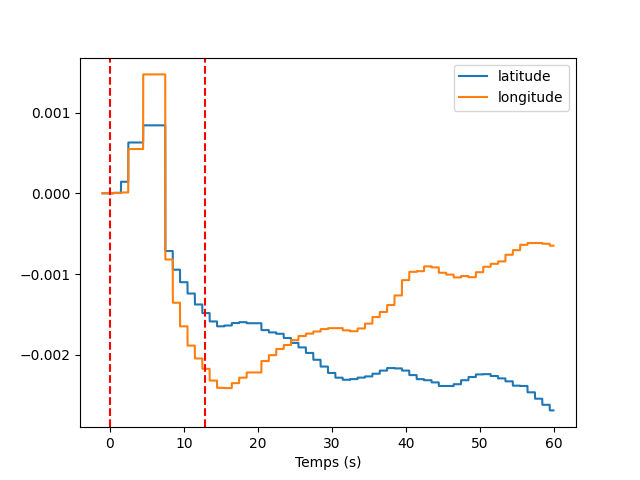

In [7]:
plt.figure()
plt.plot(t_info[id_t0_info:id_tf_info]-decollage_info, (df_info['lat'][id_t0_info:id_tf_info] - df_info['lat'][id_t0_info])*factor_gps, label = 'latitude')
plt.plot(t_info[id_t0_info:id_tf_info]-decollage_info, (df_info['lon'][id_t0_info:id_tf_info] - df_info['lon'][id_t0_info])*factor_gps, label = 'longitude')
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.legend()
plt.xlabel('Temps (s)')

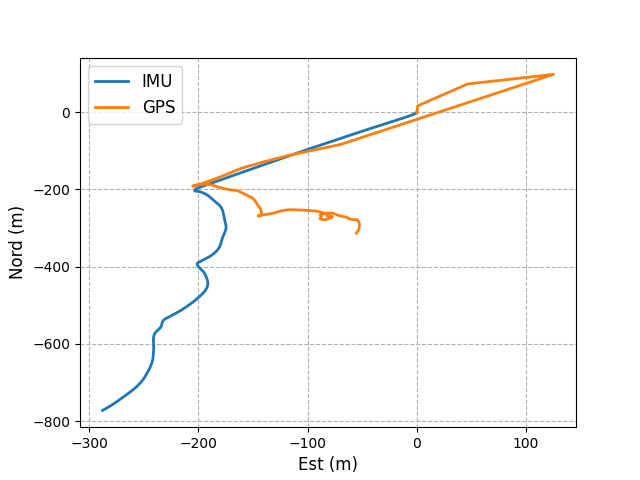

In [8]:
# factor_gps = max(x[id_t0_cam:id_tf_cam][:,5]) / max(df_info['alt'][id_t0_info:id_tf_info] - df_info['alt'][id_t0_info])
factor_gps = 1 # on ne renormalise pas les données GPS pour la trajectoire
# import math
# Radius of the Earth in meters
EARTH_RADIUS = 6378137

def lat_to_meter(lat):
    """Convert latitude to meters."""
    return lat * np.pi/180 * EARTH_RADIUS

def lon_to_meter(lon, lat):
    """Convert longitude to meters at a given latitude."""
    # The radius of the Earth varies with latitude, 
    # so we multiply the Earth's radius by the cosine of the latitude.
    return lon * np.pi/180 * EARTH_RADIUS * np.cos(lat * np.pi/180)

plt.figure()
plt.plot(x[id_t0_cam:id_tf_cam,3], x[id_t0_cam:id_tf_cam,4],linewidth=2)
plt.plot(factor_gps*(lon_to_meter(df_info["lon"][id_t0_info:id_tf_info], df_info["lat"][id_t0_info:id_tf_info])-lon_to_meter(df_info["lon"].iloc[id_t0_info], df_info["lat"].iloc[id_t0_info])), factor_gps * (lat_to_meter(df_info["lat"][id_t0_info:id_tf_info])-lat_to_meter(df_info["lat"].iloc[id_t0_info])),linewidth=2)
plt.xlabel('Est (m)',size=12)
plt.ylabel('Nord (m)',size=12)
plt.legend(['IMU','GPS'],fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"trajectoire_gps_{file_name_suffix}.png")
plt.show()

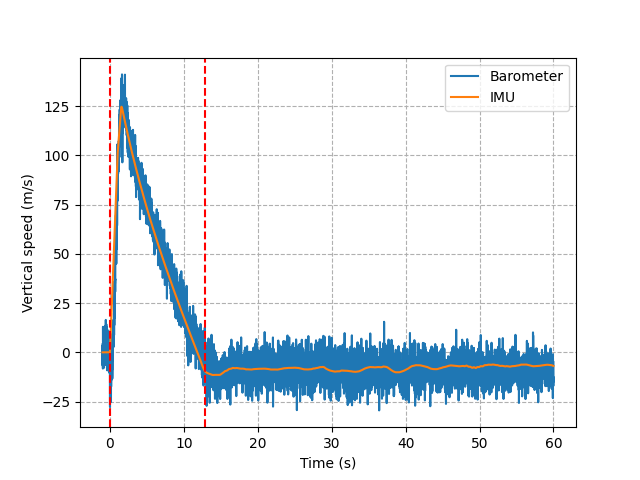

In [9]:

factor_baro = max(x[id_t0_cam:id_tf_cam][:,5]) / max(df_info['altitude'][id_t0_info:id_tf_info] - df_info['altitude'][id_t0_info])
baro_speed = factor_baro * (df_info['altitude'] - df_info['altitude'].shift(100)) / (df_info['microstime'] - df_info['microstime'].shift(100)) * 1e6

plt.figure()
plt.plot(t_info[id_t0_info:id_tf_info]-decollage_info, baro_speed[id_t0_info:id_tf_info],linewidth=2)
plt.plot(t_cam[id_t0_cam:id_tf_cam]-decollage_cam, x[id_t0_cam:id_tf_cam][:,2], linewidth = 2)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)', size=12)
plt.ylabel('Vitesse verticale (m/s)', size=12)
plt.legend(['Baromètre', 'IMU'], fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(linestyle='--')
plt.savefig(f"vitesse_verticale_{file_name_suffix}.png")
plt.show()


In [10]:
alpha_v = np.arctan2(-x[:, 0], x[:, 1])

plt.figure()
plt.plot(t_info[id_t0_info:id_tf_info]-decollage_info, df_info["course"][id_t0_info:id_tf_info])
plt.plot(t_cam[id_t0_cam:id_tf_cam]-decollage_cam, (np.unwrap(alpha_v[id_t0_cam:id_tf_cam]))*180/np.pi+360)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Course (°)')
plt.legend(['Course GPS', 'Course IMU'])
plt.grid(linestyle='--')
plt.savefig(f"course_{file_name_suffix}.png")
plt.show()

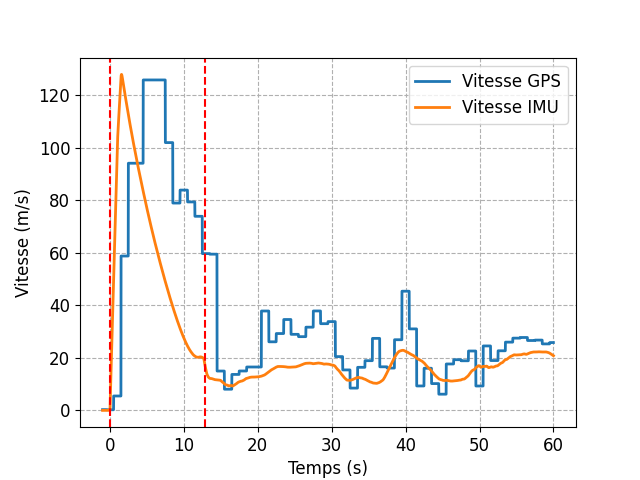

In [13]:
factor_gps = max(x[id_t0_cam:id_tf_cam][:,5]) / max(df_info['alt'][id_t0_info:id_tf_info] - df_info['alt'][id_t0_info])
vnorm = np.linalg.norm(x[:,:3], axis=1) # en m/s

plt.figure()
plt.plot(t_info[id_t0_info:id_tf_info]-decollage_info, df_info["speed"][id_t0_info:id_tf_info] * factor_gps, linewidth=2)
plt.plot(t_cam[id_t0_cam:id_tf_cam]-decollage_cam, vnorm[id_t0_cam:id_tf_cam],linewidth=2)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)',size=12)
plt.ylabel('Vitesse (m/s)',size=12)
plt.legend(['Vitesse GPS','Vitesse IMU'],fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(linestyle='--')
plt.savefig(f"speed_{file_name_suffix}.png")
plt.show()